<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Volatility

This notebook explores the relative volatity of different countries, above and below a given dollar volume threshold.

In [1]:
from quantrocket.history import get_historical_prices
from quantrocket.account import download_exchange_rates
import pandas as pd
import io

Get exchange rates (for converting non-USD stocks to USD dollar volume):

In [2]:
f = io.StringIO()
download_exchange_rates(f, latest=True, base_currencies="USD")
rates = pd.read_csv(f)
rates = rates.set_index("QuoteCurrency").Rate.to_dict()

In [3]:
def get_std(db, start_date, min_dollar_volume=0, max_dollar_volume=None, universes=None):
    """
    Returns the average standard dev of monthly, daily, overnight, and intraday returns from
    the start date until now. 
    """
    prices = get_historical_prices(
        db, 
        start_date=start_date, 
        universes=universes, 
        fields=["Close","Open","Volume"], 
        master_fields=["Currency","Multiplier","PriceMagnifier"])
        
    closes = prices.loc["Close"]
    opens = prices.loc["Open"]
    
    volumes = prices.loc["Volume"]
    currencies = prices.loc["Currency"]
    multipliers = prices.loc["Multiplier"].reindex(closes.index, method="ffill")
    magnifiers = prices.loc["PriceMagnifier"].reindex(closes.index, method="ffill")
    exchange_rates = currencies.applymap(lambda x: rates[x])
    exchange_rates = exchange_rates.reindex(closes.index, method="ffill")
    closes = closes * multipliers.fillna(1) / magnifiers.fillna(1)
    opens = opens * multipliers.fillna(1) / magnifiers.fillna(1)
    dollar_volumes = closes.div(exchange_rates) * volumes
    sufficient_dollar_volumes = dollar_volumes >= min_dollar_volume
    if max_dollar_volume:
        sufficient_dollar_volumes = sufficient_dollar_volumes & (dollar_volumes <= max_dollar_volume)
    
    monthly_returns = (closes - closes.shift(22)) / closes.shift(22)
    monthly_returns = monthly_returns.where(sufficient_dollar_volumes)
    monthly_returns = monthly_returns.where((monthly_returns > -0.9) & (monthly_returns < 9), 0)
    monthly_std = monthly_returns.std().mean()
    
    cc_returns = closes.pct_change().where(sufficient_dollar_volumes)
    # Ignore outliers
    cc_returns = cc_returns.where((cc_returns > -0.9) & (cc_returns < 9), 0)
    cc_std = cc_returns.std().mean()
    
    co_returns = (opens - closes.shift()) / closes.shift()
    co_returns = co_returns.where(sufficient_dollar_volumes)
    co_returns = co_returns.where((co_returns > -0.9) & (co_returns < 9), 0)
    co_std = co_returns.std().mean()
    
    oc_returns = (closes - opens) / opens
    oc_returns = oc_returns.where(sufficient_dollar_volumes)
    oc_returns = oc_returns.where((oc_returns > -0.9) & (oc_returns < 9), 0)
    oc_std = oc_returns.std().mean()
    
    return {
        "monthly": monthly_std,
        "daily": cc_std,
        "intraday (open-to-close)": oc_std,
        "overnight (close-to-open)": co_std,
    }

Countries for which numbers should be run:

In [4]:
countries = (
    # North America
    ("usa-stk-1d", "United States"),
    ("canada-stk-1d", "Canada"),
    ("mexico-stk-1d", "Mexico"),
    
    # Asia
    ("australia-stk-1d", "Australia"),
    ("japan-stk-1d", "Japan"),
    ("hongkong-stk-1d", "Hong Kong"),
    ("singapore-stk-1d", "Singapore"),
    
    # Europe
    ("spain-stk-1d", "Spain"),
    ("netherlands-stk-1d", "Netherlands"),
    ("uk-stk-1d", "United Kingdom"),
    ("germany-stk-1d", "Germany"),
    ("france-stk-1d", "France"),
    ("belgium-stk-1d", "Belgium"),
    ("swiss-stk-1d", "Switzerland"),
    ("austria-stk-1d", "Austria"),
    ("sweden-stk-1d", "Sweden"),
    ("italy-stk-1d", "Italy"),
)

Run numbers for each country:

In [5]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette=sns.color_palette('deep', n_colors=3))

Text(0,0.5,'Standard deviation (%)')

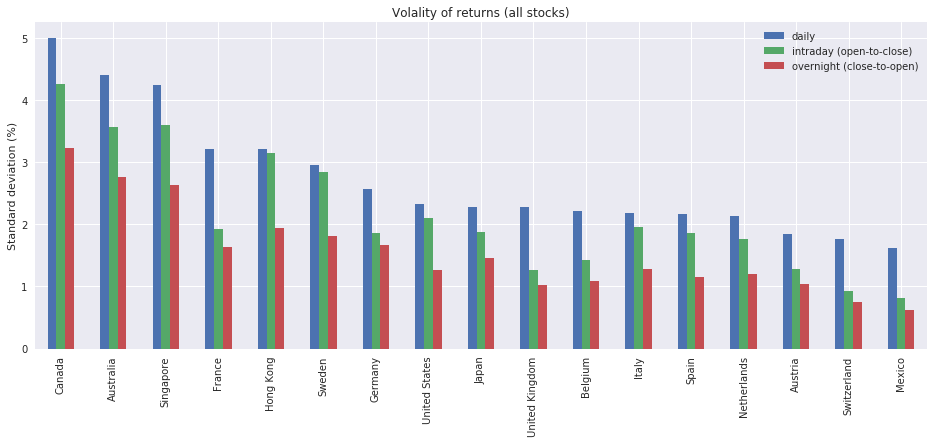

In [8]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volality of returns (all stocks)", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

Repeat with a minimum dollar volume threshold of $1M USD:

In [9]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date, min_dollar_volume=1000000)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


Text(0,0.5,'Standard deviation (%)')

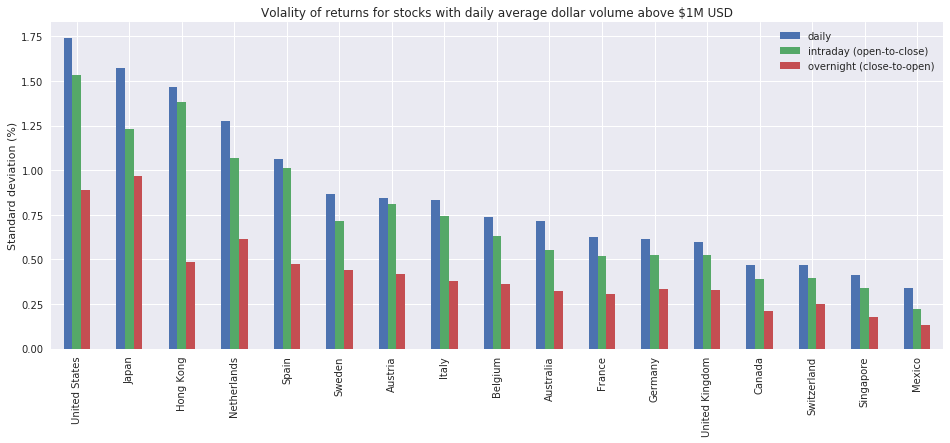

In [10]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volality of returns for stocks with daily average dollar volume above $1M USD", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

Repeat with a maximum dollar volume threshold of $1M USD: 

In [11]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date, max_dollar_volume=1000000)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


Text(0,0.5,'Standard deviation (%)')

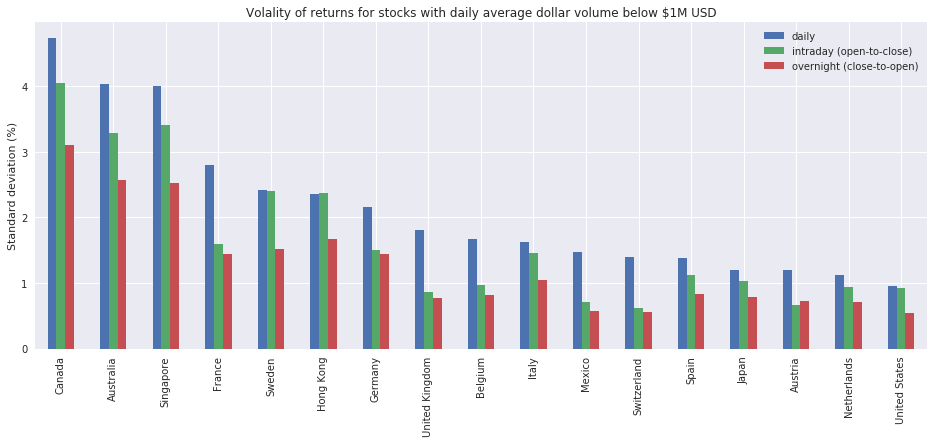

In [12]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volality of returns for stocks with daily average dollar volume below $1M USD", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

***

[Back to Introduction](Introduction.ipynb)